# CSE527 Programming Assignment 4
**Due date: 23:59 on November 26th 2021**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
You train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead you fine-tune a pre-trained network as in this problem.

In Problem 1, you will be finetuning a pretrained resnet and using it to classify JPL interaction video frames. 

For Problem 2, you are going to use thread pooling/convolution to classify the video files using the similar pretrained network as your baseline model.



There are 2 problems in this homework with a total of 120 points including 20 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the dataset(click me) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/MyDrive/CSE527/Shah_Manal_114362205_PA4'

/content/gdrive/MyDrive/CSE527/Shah_Manal_114362205_PA4


## Problem 1 Data Preparation and Fine-tuning
## First-Person Activity Recognition: What Are They Doing to Me?
In this part of the assignment, you will implement an Activity Classifier using JPL dataset. You will use an an ImageNet pre-trained CNN that serves as a feature extractor.
## About JPL dataset
This first-person dataset contains videos of interactions between humans and the observer. We attached a GoPro2 camera to the head of our humanoid model, and asked human participants to interact with the humanoid by performing activities. In order to emulate the mobility of a real robot, we also placed wheels below the humanoid and made an operator to move the humanoid by pushing it from the behind. Videos were recorded continuously during human activities where each video sequence contains 0 to 3 activities. The videos are in 320*240 resolution with 30 fps.

There are 7 different types of activities in the dataset, including :
<ol>

###4 positive (i.e., friendly) interactions with the observer: 

<li> 'Shaking hands with the observer', <li> 'hugging the observer', <li> 'petting the observer', and <li> 'waving a hand to the observer' 

###1 neutral interaction:
<li>  the situation where two persons have a conversation about the observer while occasionally pointing it.

###2 negative (i.e., hostile) interactions: 
<li>  'Punching the observer' and <li> 'throwing objects to the observer'
</ol>
We will thus assign label to each action, for example:


```
{
  'Shaking hands with the observer': 1, 
  'hugging the observer': 2, 
  'petting the observer': 3, 
  'waving a hand to the observer': 4,
  'the situation where two persons have a conversation about the observer while occasionally pointing it': 5,
  'Punching the observer': 6,
  'throwing objects to the observer': 7
}
```



### Problem 1.0
## Loading the JPL dataset: 5 points
Check the segmented version from [here](https://drive.google.com/file/d/1eivyF3gPbS3ejea-NYebMBzS40xsRrqF/view?usp=sharing). 
Save the videos into your working folder in your Google Drive.
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the jpl_vid directory where you should extract the jpl dataset. Do not upload the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID. 
In the first part of data preparation, we will convert the videos into images. We will only use all frames from each video and store them as .jpg files. The data folder now also consists of two other directories: jpl_vid, jpl_img. **We will delete the jpl_img directory from you data folder before evaluating.**


In [ ]:
# !rmdir ./data/jpl_img/

In [ ]:
def get_frames(filename, n_frames= -1):
#--------------------------------------------------
#       given the filename of a video,  generate all the frames for that video and return it with length of the frame
#       Example: if path /data/jpl_img/10_1/ should contain the frames from 10_1.avi

#       if n_frames is -1 store all the frames of the video. 
#       Else we will only use n_frames frames from each video that are equally spaced across the entire video and store them as .jpg files.
#       We expect you to use CV2 library to read video frames.
#--------------------------------------------------
    vid_obj = cv2.VideoCapture(filename)
    flag = 1
    frames = []
    while flag:
      flag, image = vid_obj.read()
      frames.append(image)

    if n_frames != -1:
      frames_required = [frames[i] for i in np.linspace(0,len(frames),n_frames, dtype = int, endpoint = False)]
      frames = frames_required

    v_len = len(frames)
    return frames, v_len

def store_frames(frames, path2store):
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)

In [ ]:
import os

path2data = "./data"
sub_folder = "jpl_vid"
sub_folder_jpg = "jpl_img"
path2video = os.path.join(path2data, sub_folder)
listOfCategories = os.listdir(path2video)
# listOfCategories, len(listOfCategories)

In [ ]:
n_frames = 16

In [ ]:
extension = ".avi"
#--------------------------------------------------
#choose a value for n_frames below to optimize your solution. We might randomly choose n_frames while evaluating 
#--------------------------------------------------
n_frames = 16
for root, dirs, files in os.walk(path2video, topdown=False):
    for name in files:
        if extension not in name:
            continue
        path2vid = os.path.join(root, name)
        frames, vlen = get_frames(path2vid, n_frames= n_frames)
        path2store = path2vid.replace(sub_folder, sub_folder_jpg)
        path2store = path2store.replace(extension, "")
        print(path2store)
        os.makedirs(path2store, exist_ok= True)
        store_frames(frames, path2store)
    print("-"*50) 

./data/jpl_img/9_3
./data/jpl_img/9_1
./data/jpl_img/11_7
./data/jpl_img/11_6
./data/jpl_img/11_3
./data/jpl_img/9_2
./data/jpl_img/9_5
./data/jpl_img/9_6
./data/jpl_img/9_7
./data/jpl_img/11_1
./data/jpl_img/11_4
./data/jpl_img/11_5
./data/jpl_img/9_4
./data/jpl_img/8_2
./data/jpl_img/8_3
./data/jpl_img/10_5
./data/jpl_img/11_2
./data/jpl_img/4_4_2
./data/jpl_img/12_7
./data/jpl_img/10_3
./data/jpl_img/12_1
./data/jpl_img/10_7
./data/jpl_img/12_4
./data/jpl_img/12_5
./data/jpl_img/4_4_1
./data/jpl_img/10_4
./data/jpl_img/12_6
./data/jpl_img/10_6
./data/jpl_img/8_1
./data/jpl_img/8_6
./data/jpl_img/12_3
./data/jpl_img/10_1
./data/jpl_img/8_7
./data/jpl_img/8_4
./data/jpl_img/12_2
./data/jpl_img/10_2
./data/jpl_img/8_5
./data/jpl_img/4_6
./data/jpl_img/4_7
./data/jpl_img/6_4
./data/jpl_img/6_5
./data/jpl_img/2_1
./data/jpl_img/6_3
./data/jpl_img/4_1
./data/jpl_img/2_7
./data/jpl_img/2_3
./data/jpl_img/4_5
./data/jpl_img/6_7
./data/jpl_img/6_6
./data/jpl_img/2_2
./data/jpl_img/5_4
./data

## Training, Test and Validation set
**Training set:**
Participant 1-9


**Test set:**
Participant 10 - 12

In [ ]:
def prepare_sets(path2ajpgs):
    listOfCats = os.listdir(path2ajpgs)
    train_id = []
    train_label = []
    test_id = []
    test_label = []
    for i in range(len(listOfCats)):
      x = listOfCats[i].split("_")
      if(int(x[0]) > 9):
        test_id.append(listOfCats[i])
        test_label.append(int(x[1]))
      else:
        train_id.append(listOfCats[i])
        train_label.append(int(x[1]))
      
    return train_id, train_label, test_id, test_label

In [ ]:
path2jpg = os.path.join(path2data, sub_folder_jpg)

In [ ]:
train_ids, train_labels, test_ids, test_labels = prepare_sets(path2jpg)

In [ ]:
train_ids, test_ids

In [ ]:
len(train_labels), len(test_labels)

(63, 21)

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)
class VideoDataset(Dataset):
    def __init__(self, ids, labels,transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(path2jpg+"/"+self.ids[idx]+"/*.jpg")
        print(path2imgs)
        path2imgs = path2imgs[:n_frames]
        label = self.labels[idx]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

### Problem 1.1
## Dataloader: 5 points
We now need to create scripts so that it accepts the generator that we just created

In [ ]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels,transform=transforms.ToTensor())
print(len(train_ds))

63


In [ ]:
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= transforms.ToTensor())
print(len(test_ds))

21


In [ ]:
#--------------------------------------------------
#create dataloader for all the datasets(train and test) 
#--------------------------------------------------
train_dl = DataLoader(train_ds, batch_size = 5, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = 5, shuffle = False)

In [ ]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

['./data/jpl_img/9_1/frame0.jpg', './data/jpl_img/9_1/frame1.jpg', './data/jpl_img/9_1/frame2.jpg', './data/jpl_img/9_1/frame3.jpg', './data/jpl_img/9_1/frame4.jpg', './data/jpl_img/9_1/frame5.jpg', './data/jpl_img/9_1/frame6.jpg', './data/jpl_img/9_1/frame7.jpg', './data/jpl_img/9_1/frame8.jpg', './data/jpl_img/9_1/frame9.jpg', './data/jpl_img/9_1/frame10.jpg', './data/jpl_img/9_1/frame11.jpg', './data/jpl_img/9_1/frame12.jpg', './data/jpl_img/9_1/frame13.jpg', './data/jpl_img/9_1/frame14.jpg', './data/jpl_img/9_1/frame15.jpg']
torch.Size([1, 16, 3, 240, 320]) torch.Size([1])


In [ ]:
#next(iter(train_dl))

In [ ]:
imgs_and_lables = list(iter(train_dl))
test_imgs_and_lables = list(iter(test_dl))

['./data/jpl_img/9_1/frame0.jpg', './data/jpl_img/9_1/frame1.jpg', './data/jpl_img/9_1/frame2.jpg', './data/jpl_img/9_1/frame3.jpg', './data/jpl_img/9_1/frame4.jpg', './data/jpl_img/9_1/frame5.jpg', './data/jpl_img/9_1/frame6.jpg', './data/jpl_img/9_1/frame7.jpg', './data/jpl_img/9_1/frame8.jpg', './data/jpl_img/9_1/frame9.jpg', './data/jpl_img/9_1/frame10.jpg', './data/jpl_img/9_1/frame11.jpg', './data/jpl_img/9_1/frame12.jpg', './data/jpl_img/9_1/frame13.jpg', './data/jpl_img/9_1/frame14.jpg', './data/jpl_img/9_1/frame15.jpg']
['./data/jpl_img/9_5/frame0.jpg', './data/jpl_img/9_5/frame1.jpg', './data/jpl_img/9_5/frame2.jpg', './data/jpl_img/9_5/frame3.jpg', './data/jpl_img/9_5/frame4.jpg', './data/jpl_img/9_5/frame5.jpg', './data/jpl_img/9_5/frame6.jpg', './data/jpl_img/9_5/frame7.jpg', './data/jpl_img/9_5/frame8.jpg', './data/jpl_img/9_5/frame9.jpg', './data/jpl_img/9_5/frame10.jpg', './data/jpl_img/9_5/frame11.jpg', './data/jpl_img/9_5/frame12.jpg', './data/jpl_img/9_5/frame13.jpg'

In [ ]:
def get_batches(imgs_labels):
  batch_data, batch_labels = [], []
  for imgs_, labels_ in imgs_labels:
    c = imgs_.view(-1, *imgs_.shape[2:])
    batch_data.append(c)
    outputs = []
    for l in  labels_.data.tolist():
      tensor = torch.full((n_frames,), l-1)
      outputs.append(tensor) 
    batch_labels.append(torch.cat(outputs, dim=0))
  return list(zip(batch_data, batch_labels))

In [ ]:
imgs_and_lables[0][0].size()

torch.Size([5, 16, 3, 240, 320])

In [ ]:
training_imgs = get_batches(imgs_and_lables)
test_imgs = get_batches(test_imgs_and_lables)

In [ ]:
training_imgs[0][0].size(), training_imgs[0][1].size()

(torch.Size([80, 3, 240, 320]), torch.Size([80]))

In [ ]:
test_imgs[0][0].size(), test_imgs[0][1].size()

(torch.Size([80, 3, 240, 320]), torch.Size([80]))

In [ ]:
classes = {
  1: "Shaking", 
  2: "Hugging", 
  3: "Petting", 
  4: "Waving",
  5: "Pointing",
  6: "Punching",
  7: "Throwing",
}

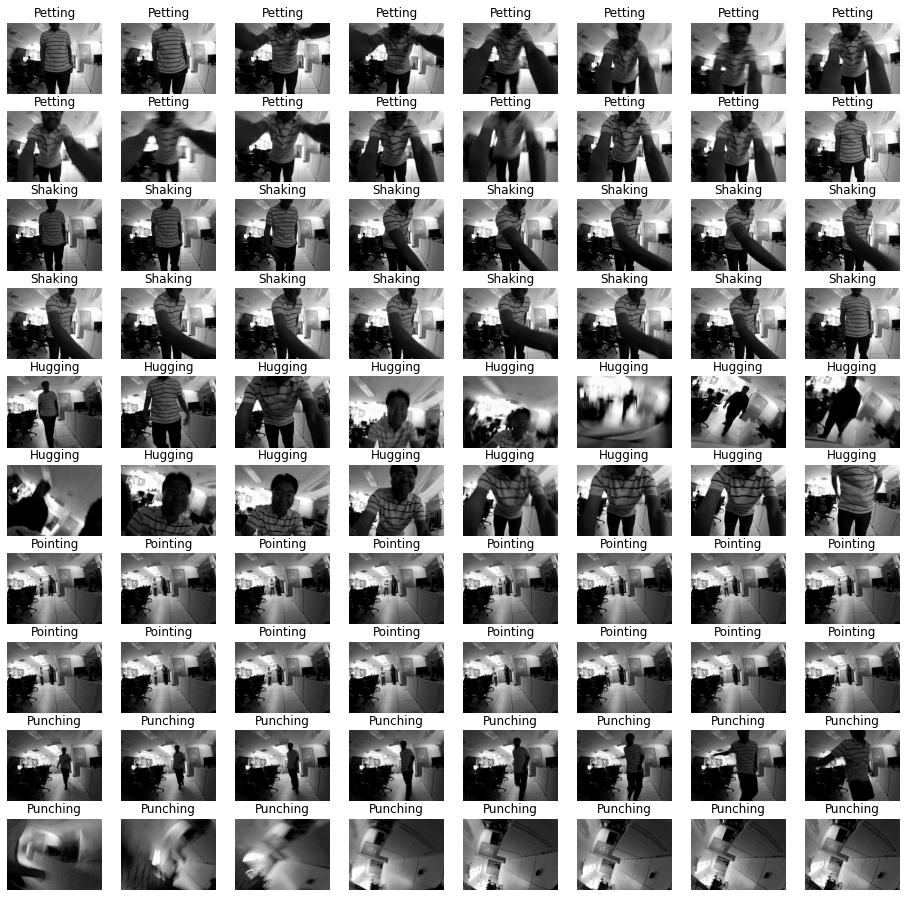

In [ ]:
figure = plt.figure(figsize=(16, 16))
cols, rows = 8, 10
for i in range(0, cols * rows):
    img, label = training_imgs[0][0][i][0], training_imgs[0][1][i].item() + 1
    figure.add_subplot(rows, cols, i+1)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

## Problem 1.2: Fine Tuning a Pre-Trained Deep Network: 40 points
The representations learned by deep convolutional networks generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385).


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

###Problem 1.2.1

##*Fine-tune* an existing network: 30 points
 In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 7 classes) this is an attractive option. In [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.
 You are required to implement above strategy to fine-tune a pre-trained **ResNet** for this video frames classification task with 7 classes.



In [ ]:
for i, (images, labels) in enumerate(training_imgs):
          print(images.size(), labels.size())

torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([48, 3, 240, 320]) torch.Size([48])


In [ ]:
for i, (images, labels) in enumerate(test_imgs):
          print(images.size(), labels.size())

torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([80, 3, 240, 320]) torch.Size([80])
torch.Size([16, 3, 240, 320]) torch.Size([16])


I have used pretrained Resnet50 model. Dropout layer with 0.5 dropout rate is added and linear layer of last fully connected layer has been changed to classify 7 classes. 

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
from torchvision import models
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 7)
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import gc
gc.collect()

217

###Problem 1.2.2
###Training and Testing your fine-tuned Network: 10 points
You will fine-tune your network using every frame in the video as a sample with the class label. Use train_dl and test_dl and feed it to your fine-tuned network. Please provide detailed descriptions of:<br>
(1) which layers of Resnet have been replaced<br>
(2) the architecture of the new layers added including activation methods <br>
(3) the final accuracy on test set <br>

1. I have used pretrained Resnet50 model. Only last layer is changed in the resnet model. 

Changes:
- Dropout layer with 0.5 dropout rate is added. 
- Linear layer has been changed to classify 7 classes. (in_2048 to out_1000 -> in_2048 to out_7)

2. Summary of the model including new layers and changes

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 240, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 160]           9,408
       BatchNorm2d-2         [-1, 64, 120, 160]             128
              ReLU-3         [-1, 64, 120, 160]               0
         MaxPool2d-4           [-1, 64, 60, 80]               0
            Conv2d-5           [-1, 64, 60, 80]           4,096
       BatchNorm2d-6           [-1, 64, 60, 80]             128
              ReLU-7           [-1, 64, 60, 80]               0
            Conv2d-8           [-1, 64, 60, 80]          36,864
       BatchNorm2d-9           [-1, 64, 60, 80]             128
             ReLU-10           [-1, 64, 60, 80]               0
           Conv2d-11          [-1, 256, 60, 80]          16,384
      BatchNorm2d-12          [-1, 256, 60, 80]             512
           Conv2d-13          [-1, 256, 60, 80]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def get_accuracy(labels_pred, lables):
  correct_preds = (labels_pred == labels).sum().item()
  return correct_preds / labels.size(0)

In [ ]:
#--------------------------------------------------
#       Train your model
#--------------------------------------------------

epochs = 20
lr = 0.0005

#Adam
optimizer = optim.Adam(model.parameters(), lr=lr)

#Cross-Entropy loss 
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
       
model.train()
accuracies = []

for epoch in range(epochs):
  for i, (images, labels) in enumerate(training_imgs):
    if torch.cuda.is_available():
      images, labels = images.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, labels_pred = torch.max(outputs.data, 1)
    acc = get_accuracy(labels_pred, labels)
    accuracies.append(acc)

    if i % (len(training_imgs) - 1) == 0 and i !=0 :
      print('[%d/%d], loss: %.3f, accuracy(pct): %.2f' % (epoch + 1, epochs, 
                                                          loss.item(),
                                                          acc * 100))
print('Finished Training')

[1/20], loss: 1.750, accuracy(pct): 37.50
[2/20], loss: 1.569, accuracy(pct): 41.67
[3/20], loss: 0.810, accuracy(pct): 64.58
[4/20], loss: 0.728, accuracy(pct): 68.75
[5/20], loss: 0.181, accuracy(pct): 100.00
[6/20], loss: 0.301, accuracy(pct): 95.83
[7/20], loss: 0.278, accuracy(pct): 95.83
[8/20], loss: 0.076, accuracy(pct): 100.00
[9/20], loss: 0.061, accuracy(pct): 100.00
[10/20], loss: 0.035, accuracy(pct): 100.00
[11/20], loss: 0.021, accuracy(pct): 100.00
[12/20], loss: 0.025, accuracy(pct): 100.00
[13/20], loss: 0.016, accuracy(pct): 100.00
[14/20], loss: 0.010, accuracy(pct): 100.00
[15/20], loss: 0.007, accuracy(pct): 100.00
[16/20], loss: 0.005, accuracy(pct): 100.00
[17/20], loss: 0.003, accuracy(pct): 100.00
[18/20], loss: 0.003, accuracy(pct): 100.00
[19/20], loss: 0.003, accuracy(pct): 100.00
[20/20], loss: 0.002, accuracy(pct): 100.00
Finished Training


In [ ]:
#--------------------------------------------------
#       Test your model
#--------------------------------------------------
model.eval()
with torch.no_grad():
  correct_preds = 0
  total_labels = 0
  for images, labels in test_imgs:
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

      outputs = model(images)
      _, preds = torch.max(outputs.data, 1)
      total_labels += labels.size(0)
      correct_preds += (preds == labels).sum().item()

  print('Test Accuracy : {} %'.format((correct_preds / total_labels) * 100))

Test Accuracy : 52.67857142857143 %


**Best Test accuracy was achieved at 20 epochs *and 0.0005 lr. Batch size used is 5(80 images = 16 frames * 5) and dropout rate is 0.5.**

***Test Accuracy : 52.68%***

Hyper Parameter Tuning results

In [ ]:
#RESNET50, epochs = 20, lr = 0.0005, batch_size = 5, dropout = 0.5

Test Accuracy: 51.488095238095234 %


In [ ]:
#RESNET50, epochs = 20, lr = 0.0005, batch_size = 4, dropout = 0.5

Test Accuracy: 47.91666666666667 %


In [ ]:
#RESNET18, epochs = 20, lr = 0.0005 , batch_size = 4, dropout=0.5

Test Accuracy: 46.726190476190474 %


In [ ]:
#RESNET50, epochs = 20, lr = 0.0001, batch_size = 5, dropout = 0.5

Test Accuracy: 40.773809523809526 %


Save and Load weights

In [ ]:
path2weights = "./models/m2.pt"
torch.save(model.state_dict(), path2weights)

In [ ]:
model.load_state_dict(torch.load("./models/m2.pt"))

<All keys matched successfully>

## Problem 2: Video Classification
### Previous Implementation
This dataset was released as a part of the [paper](http://michaelryoo.com/papers/cvpr2013_ryoo.pdf) in CVPR 2013. The paper investigates multichannel kernels to integrate global and local motion information, and presents a new activity learning/recognition methodology that explicitly considers temporal structures displayed in first-person activity videos. As stated in the paper, *We first introduce video features designed to capture
global motion (Subsection 3.1) and local motion (Subsection 3.2) observed during humans’ various interactions with
the observer. Next, in Subsection 3.3, we cluster features to
form visual words and obtain histogram representations. In
Subsection 3.4, multi-channel kernels are described.* These features were prepared for an input to the SVM.

###Using CNNs
In this approach of video classification we are using an image classifier on every single frame of the video. We then have to merge the feature vectors obtained per frames using a fusion layer. This need to be built into the network itself. A Fusion layer is used to merge the output of separate networks that operate on temporally distant frames. It is normally implemented using the max pooling, average pooling or flattening technique. We then define a fully connected layer to provide the output.



### Problem 2.1
### Temporal Pooling: 20 points
As suggested in this [paper](https://arxiv.org/abs/1503.08909), we position the temporal pooling layer right before the ﬁrst fully connected layer as illustrated. This layer performs either mean-pooling or max-pooling across all video frames. The structure of the CNN-component is identical single-frame model. This network is able to collect all the spatial features in a given time window. However, the order of the temporal events is lost due to the nature of pooling across frames


## ***Temporal Pooling is implemented as part of 2.2 after feature extraction.***



### Problem 2.2
### Network Definition: 20 points
### Feature Extraction using an ImageNet pre-trained CNN 
Use a fine-tuned resNet model that you used in Part1 to extract the features from every video frames.



In [ ]:
#Tweaking pre trained model of Q1 for extracting features
model1 = model
model1.fc = model1.fc[:1]

for param in model1.parameters():
    param.requires_grad = False
print(model1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Feature Extraction

def getFeatures(model, imgs_labels):
  model.eval() 

  if torch.cuda.is_available():
    model = model.cuda()
  
  feature_samples = []
  for images, labels in imgs_labels:

      if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()

      features = model(images)
      video_features = list(features.split(n_frames, dim=0))

      for i in range(len(video_features)):
        model_features = []
        for j in range(len(video_features[i])):
          model_features.append(torch.cat((video_features[i][j], labels[i].reshape(1)), dim=0))
        feature_samples.extend(model_features)
        
  print(torch.stack(feature_samples).size())

  return torch.stack(feature_samples)

In [ ]:
train_samples = getFeatures(model1, training_imgs)

torch.Size([1008, 2049])


Video Train Tensors: [63,16,2048] 63 videos, 16 frames each and 2048 feature vector

In [ ]:
train_feature_tensor = torch.stack(torch.split(train_samples[:,:-1], n_frames, dim=0))
train_label_tensor = torch.mean(torch.stack(torch.split(train_samples[:, -1], n_frames, dim=0)), dim=1)
train_feature_tensor.size(), train_label_tensor.size()

(torch.Size([63, 16, 2048]), torch.Size([63]))

In [ ]:
import pickle
with open('train_feature_tensor.pkl', 'wb') as fid:
     pickle.dump(train_feature_tensor, fid)
with open('train_label_tensor.pkl', 'wb') as fid:
     pickle.dump(train_label_tensor, fid)

In [ ]:
test_samples = getFeatures(model1, test_imgs)

torch.Size([336, 2049])


Video Test Tensors: [21,16,2048] 21 videos, 16 frames each and 2048 feature vector

In [ ]:
test_feature_tensor = torch.stack(torch.split(test_samples[:,:-1], n_frames, dim=0))
test_label_tensor = torch.mean(torch.stack(torch.split(test_samples[:, -1], n_frames, dim=0)), dim=1)
test_feature_tensor.size(), train_label_tensor.size()

(torch.Size([21, 16, 2048]), torch.Size([63]))

In [ ]:
with open('test_feature_tensor.pkl', 'wb') as fid:
     pickle.dump(test_feature_tensor, fid)
with open('test_label_tensor.pkl', 'wb') as fid:
     pickle.dump(test_label_tensor, fid)

In [ ]:
import pickle
with open('train_feature_tensor.pkl', 'rb') as pickle_in:
     train_feature_tensor = pickle.load(pickle_in)
with open('train_label_tensor.pkl', 'rb') as pickle_in:
     train_label_tensor = pickle.load(pickle_in)

In [ ]:
with open('test_feature_tensor.pkl', 'rb') as pickle_in:
     test_feature_tensor = pickle.load(pickle_in)
with open('test_label_tensor.pkl', 'rb') as pickle_in:
     test_label_tensor = pickle.load(pickle_in)

**Max Pooling across temoral dimension of n_frames**

Shape before pooling across temporal dimension

In [ ]:
train_feature_tensor.size(), test_feature_tensor.size()

(torch.Size([63, 16, 2048]), torch.Size([21, 16, 2048]))

Max pool across dim 1

In [ ]:
_, train_features = torch.max(train_feature_tensor, dim = 1)
_, test_features = torch.max(test_feature_tensor, dim = 1)

Shape after pooling across temporal dimension

In [ ]:
train_features.shape, test_features.shape

(torch.Size([63, 2048]), torch.Size([21, 2048]))

### Problem 2.2
**Train and Test:10 points**


#SVC Classifier

In [ ]:
#.cpu() to copy the tensor to host memory and converting to ndarray
trainX, trainY = train_features.cpu().numpy(), train_label_tensor.cpu().numpy()
testX, testY = test_features.cpu().numpy(), test_label_tensor.cpu().numpy() 

In [ ]:
c = 0.07
clf = SVC(C=c, kernel='linear')

clf.fit(trainX, trainY)

preds = clf.predict(testX)

print("SVM classifier Train Accuracy(pct) :%.2f"% (clf.score(trainX, trainY) * 100))
print("SVM classifier Test Accuracy(pct) :%.2f"% (accuracy_score(testY, preds) *100))

SVM classifier Train Accuracy(pct) :100.00
SVM classifier Test Accuracy(pct) :28.57


**Answer**:

Accuracy on test set: 28.57%

### Problem 2.2
**Fusion based implementation: 20 bonus points**

## Submission guidelines
---
Your need to submit a single zip file to Blackboard described as follow.

Please generate a pdf file that includes a ***google shared link*** (explained in the next paragraph). This pdf file should be named as ***Surname_Givenname_SBUID_pa*\*.pdf** (example: Jordan_Michael_111234567_pa3.pdf for this assignment).

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_pa**** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_pa4
        |---data
        |---CSE527-PA4-fall21.ipynb
```
Note that this folder should be in your Google Drive with your Stony Brook account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TA's email: ***bjha@cs.stonybrook.edu***, ***li.wenchen@stonybrook.edu***, ***yifeng.huang@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **UNCHECK** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard. 

To submit to Blackboard, zip ***Surname_Givenname_SBUID_pa*\*.pdf** and ***Surname_Givenname_SBUID_pa**** folder together and name your zip file as ***Surname_Givenname_SBUID_pa*\*.zip**. 

**DO NOT upload the datasets to Blackboard.**

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_pa4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

<!--Write your report here in markdown or html-->
